In [1]:
import pandas
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from collections import Counter
import time
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
#from keras.utils import to_categorical
import feather
import random
from datetime import *

import warnings
warnings.filterwarnings("ignore")

C:\Users\aufbpc\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\aufbpc\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\aufbpc\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\aufbpc\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

In [2]:
FILENAME = "Datasets/final/preproccesed_outliers_3353_col_7_threshold_1_"
data = pd.read_csv(f"{FILENAME}.csv")

In [3]:
data.to_feather(f"{FILENAME}.feather")

In [4]:
data = feather.read_dataframe("{}.feather".format(FILENAME))
data = data.dropna().reset_index(drop=True)

In [5]:
import censusdata

county = censusdata.download('acs5', 2018, censusdata.censusgeo([('county', '*')]),
                                   ['DP05_0001E',  'DP03_0019PE','DP03_0021PE','DP03_0022PE','DP03_0062E'],
                                   tabletype='profile')
# rename columns
county.columns = ['Population_County','Drive_County','Transit_County','Walk_County','MedianHouseholdIncome_County']
county = county.reset_index()
# extract county name and convert them to lowercase
county['County'] = county['index'].apply(lambda x : x.name.split(' County')[0].split(',')[0]).str.lower()
county['State'] = county['index'].apply(lambda x : x.name.split(', ')[1]).str.lower()
county

,index,Population_County,Drive_County,Transit_County,Walk_County,MedianHouseholdIncome_County,County,State
0,"Washington County, Mississippi: Summary level:...",47086,86.4,0.0,1.3,30834,washington,mississippi
1,"Perry County, Mississippi: Summary level: 050,...",12028,85.8,0.0,1.8,39007,perry,mississippi
2,"Choctaw County, Mississippi: Summary level: 05...",8321,85.6,0.3,1.1,37203,choctaw,mississippi
3,"Itawamba County, Mississippi: Summary level: 0...",23480,82.4,0.2,0.7,40510,itawamba,mississippi
4,"Carroll County, Mississippi: Summary level: 05...",10129,90.0,0.0,1.4,43060,carroll,mississippi
...,...,...,...,...,...,...,...,...
3215,"Clayton County, Iowa: Summary level: 050, stat...",17672,78.6,0.3,4.3,52828,clayton,iowa
3216,"Buena Vista County, Iowa: Summary level: 050, ...",20260,73.0,0.3,5.6,54556,buena vista,iowa
3217,"Guthrie County, Iowa: Summary level: 050, stat...",10674,79.1,0.2,3.6,57075,guthrie,iowa
3218,"Humboldt County, Iowa: Summary level: 050, sta...",9566,84.8,0.0,1.8,52219,humboldt,iowa


In [6]:
# Convert all county values in data to lowercase

data['State'] = data['State'].str.lower() 
data['County'] = data['County'].str.lower()

counties = []
for i in data['County'].values:
    counties.append(i.replace(' county', ''))
data['County'] = counties

In [7]:
states = pd.read_csv('Datasets/states.csv')
states.index = states['Abbreviation'].map(lambda value: value.lower())
states = states.drop('Abbreviation',axis=1)
states

,State
Abbreviation,
al,Alabama
ak,Alaska
az,Arizona
ar,Arkansas
ca,California
co,Colorado
ct,Connecticut
de,Delaware
dc,District of Columbia


In [8]:
data['State'] = [states.loc[i, 'State'] for i in data['State'].values]
data['State'] = data['State'].map(lambda value: value.lower())

In [9]:
# Create join column <state>-<county>
def concat_cols(df, cols):
    df['combined'] = df[cols].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
    return df

data = concat_cols(data, ['State', 'County'])
data.head()

,Unnamed: 0,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Street,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,combined
0,1,A-3,2.0,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,0.01,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,ohio-clermont
1,2,A-4,3.0,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,ohio-montgomery
2,3,A-5,2.0,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,ohio-montgomery
3,4,A-6,3.0,2016-02-08 07:44:26,2016-02-08 08:14:26,40.100590,-82.925194,0.01,Accident on I-270 Outerbelt Northbound near Ex...,Westerville Rd,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,ohio-franklin
4,5,A-7,2.0,2016-02-08 07:59:35,2016-02-08 08:29:35,39.758274,-84.230507,0.00,Accident on Oakridge Dr at Woodward Ave. Expec...,N Woodward Ave,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,ohio-montgomery


In [10]:
county = concat_cols(county, ['State', 'County'])
county = county.drop(['index', 'County', 'State'], axis=1)
county.head()

,Population_County,Drive_County,Transit_County,Walk_County,MedianHouseholdIncome_County,combined
0,47086,86.4,0.0,1.3,30834,mississippi-washington
1,12028,85.8,0.0,1.8,39007,mississippi-perry
2,8321,85.6,0.3,1.1,37203,mississippi-choctaw
3,23480,82.4,0.2,0.7,40510,mississippi-itawamba
4,10129,90.0,0.0,1.4,43060,mississippi-carroll


In [11]:
# left join df with census data
data = data.merge(county, left_on = 'combined', right_on='combined', how='left').drop('combined', axis=1)
data

,Unnamed: 0,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Street,...,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Population_County,Drive_County,Transit_County,Walk_County,MedianHouseholdIncome_County
0,1,A-3,2.0,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,0.010,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,...,1.0,1.0,1.0,1.0,1.0,203216.0,85.4,0.4,1.1,64822.0
1,2,A-4,3.0,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,0.010,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,...,0.0,1.0,0.0,1.0,1.0,532034.0,82.6,2.6,2.5,49314.0
2,3,A-5,2.0,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,0.010,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,...,1.0,0.0,0.0,1.0,1.0,532034.0,82.6,2.6,2.5,49314.0
3,4,A-6,3.0,2016-02-08 07:44:26,2016-02-08 08:14:26,40.100590,-82.925194,0.010,Accident on I-270 Outerbelt Northbound near Ex...,Westerville Rd,...,0.0,0.0,0.0,1.0,1.0,1275333.0,81.3,2.3,2.5,58762.0
4,5,A-7,2.0,2016-02-08 07:59:35,2016-02-08 08:29:35,39.758274,-84.230507,0.000,Accident on Oakridge Dr at Woodward Ave. Expec...,N Woodward Ave,...,0.0,0.0,0.0,1.0,1.0,532034.0,82.6,2.6,2.5,49314.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3003113,3003114,A-3513776,2.0,2019-08-23 18:03:25,2019-08-23 18:32:01,34.002480,-117.379400,0.543,At Market St - Accident.,Pomona Fwy E,...,0.0,0.0,0.0,1.0,1.0,2383286.0,77.8,1.3,1.5,63948.0
3003114,3003115,A-3513777,2.0,2019-08-23 19:11:30,2019-08-23 19:38:23,32.766960,-117.148100,0.338,At Camino Del Rio/Mission Center Rd - Accident.,I-8 W,...,0.0,0.0,0.0,1.0,1.0,3302833.0,76.3,2.9,2.9,74855.0
3003115,3003116,A-3513778,2.0,2019-08-23 19:00:21,2019-08-23 19:28:49,33.775450,-117.847800,0.561,At Glassell St/Grand Ave - Accident. in the ri...,Garden Grove Fwy,...,0.0,0.0,0.0,1.0,1.0,3164182.0,78.7,2.0,1.9,85398.0
3003116,3003117,A-3513779,2.0,2019-08-23 19:00:21,2019-08-23 19:29:42,33.992460,-118.403000,0.772,At CA-90/Marina Fwy/Jefferson Blvd - Accident.,San Diego Fwy S,...,0.0,0.0,0.0,1.0,1.0,10098052.0,73.9,6.0,2.7,64251.0


In [12]:
# The number of rows in data that did not have a corresponding values in county
print(sum(data['Walk_County'].isnull()))

# Just remove those rows from the data
data = data.dropna().reset_index(drop=True)
print(len(data))

68246
2934872


# Outlier Removal

### Visualise pre-removal

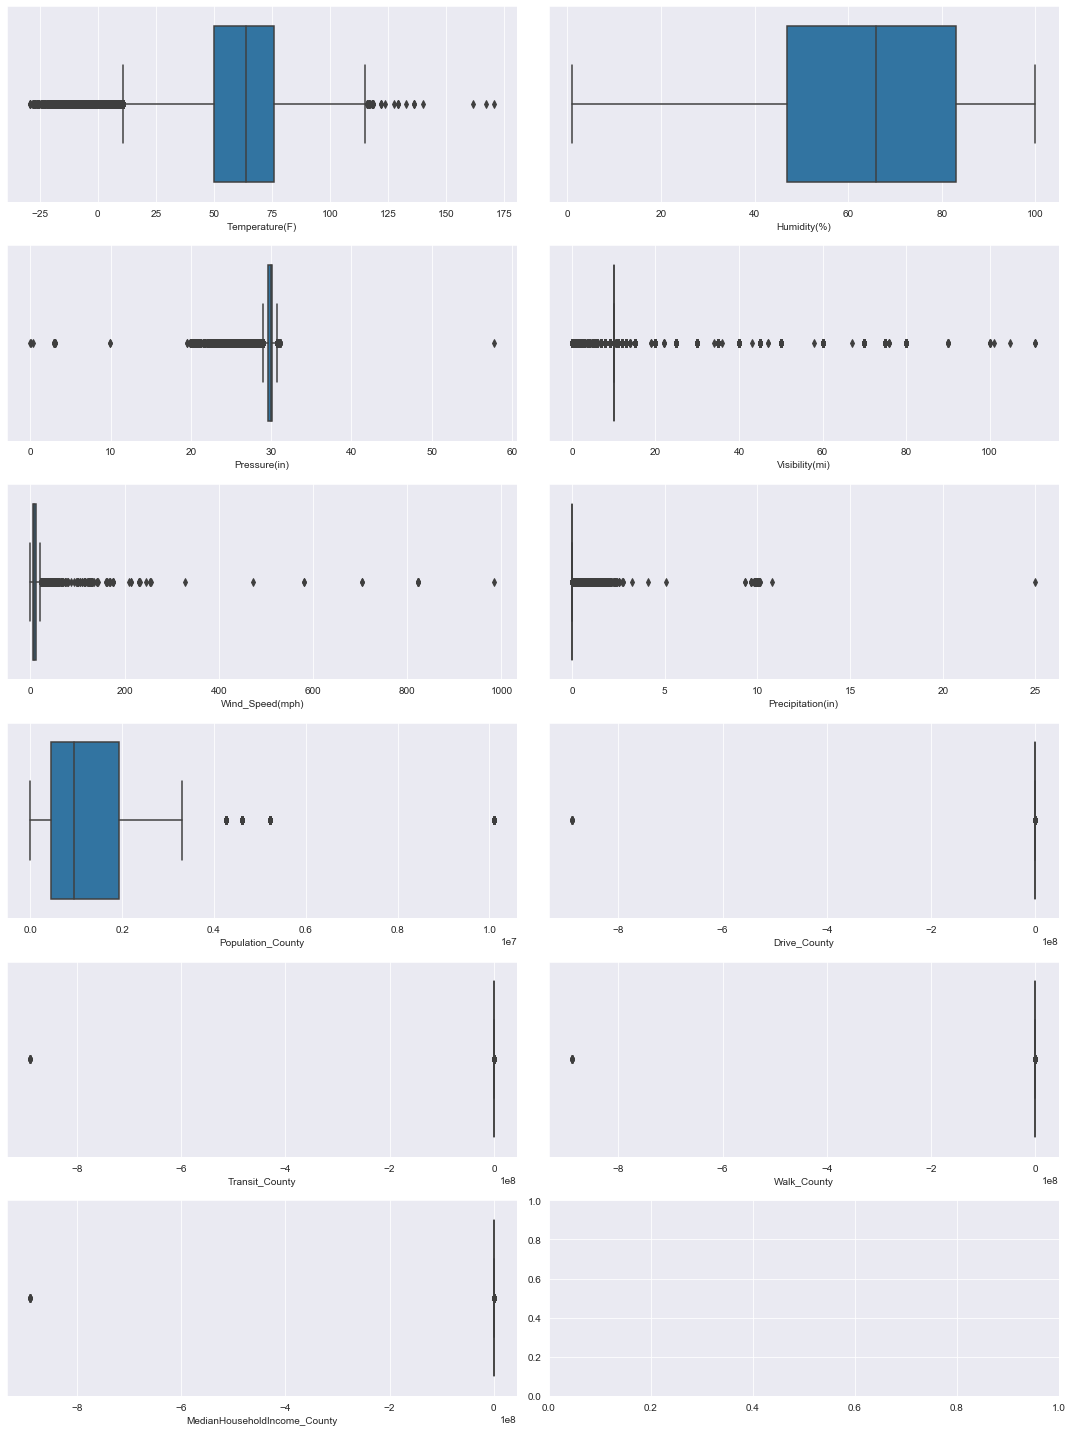

In [13]:
cols = ['Severity', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
        'Wind_Speed(mph)', 'Precipitation(in)',
       'Population_County', 'Drive_County', 'Transit_County', 'Walk_County', 'MedianHouseholdIncome_County']

sns.set_style('darkgrid')
f, axes = plt.subplots(6,2, figsize=(15,20))  
y = 0;
for name in cols[1:]:
    i, j = divmod(y, 2)
    sns.boxplot(x=data[name], ax=axes[i, j])
    y = y+1

plt.tight_layout()
plt.show()

In [14]:
# Remove the outliers

bef = len(data)
print("BEFORE REMOVAL OF OUTLIERS: ", bef)

# Pressure
data = data[(data['Pressure(in)']<=33) & (data['Pressure(in)']>15)]

# Visibility
data = data[data['Visibility(mi)']<15]

# Wind Speed
data = data[data['Wind_Speed(mph)']<200]

# Precipitation
data = data[data['Precipitation(in)']<3]

for c in ['Drive_County', 'Transit_County', 'Walk_County', 'MedianHouseholdIncome_County']:
    data=data[data[c]>=0]

print("AFTER REMOVAL OF OUTLIERS: ", len(data))

BEFORE REMOVAL OF OUTLIERS:  2934872
AFTER REMOVAL OF OUTLIERS:  2922400


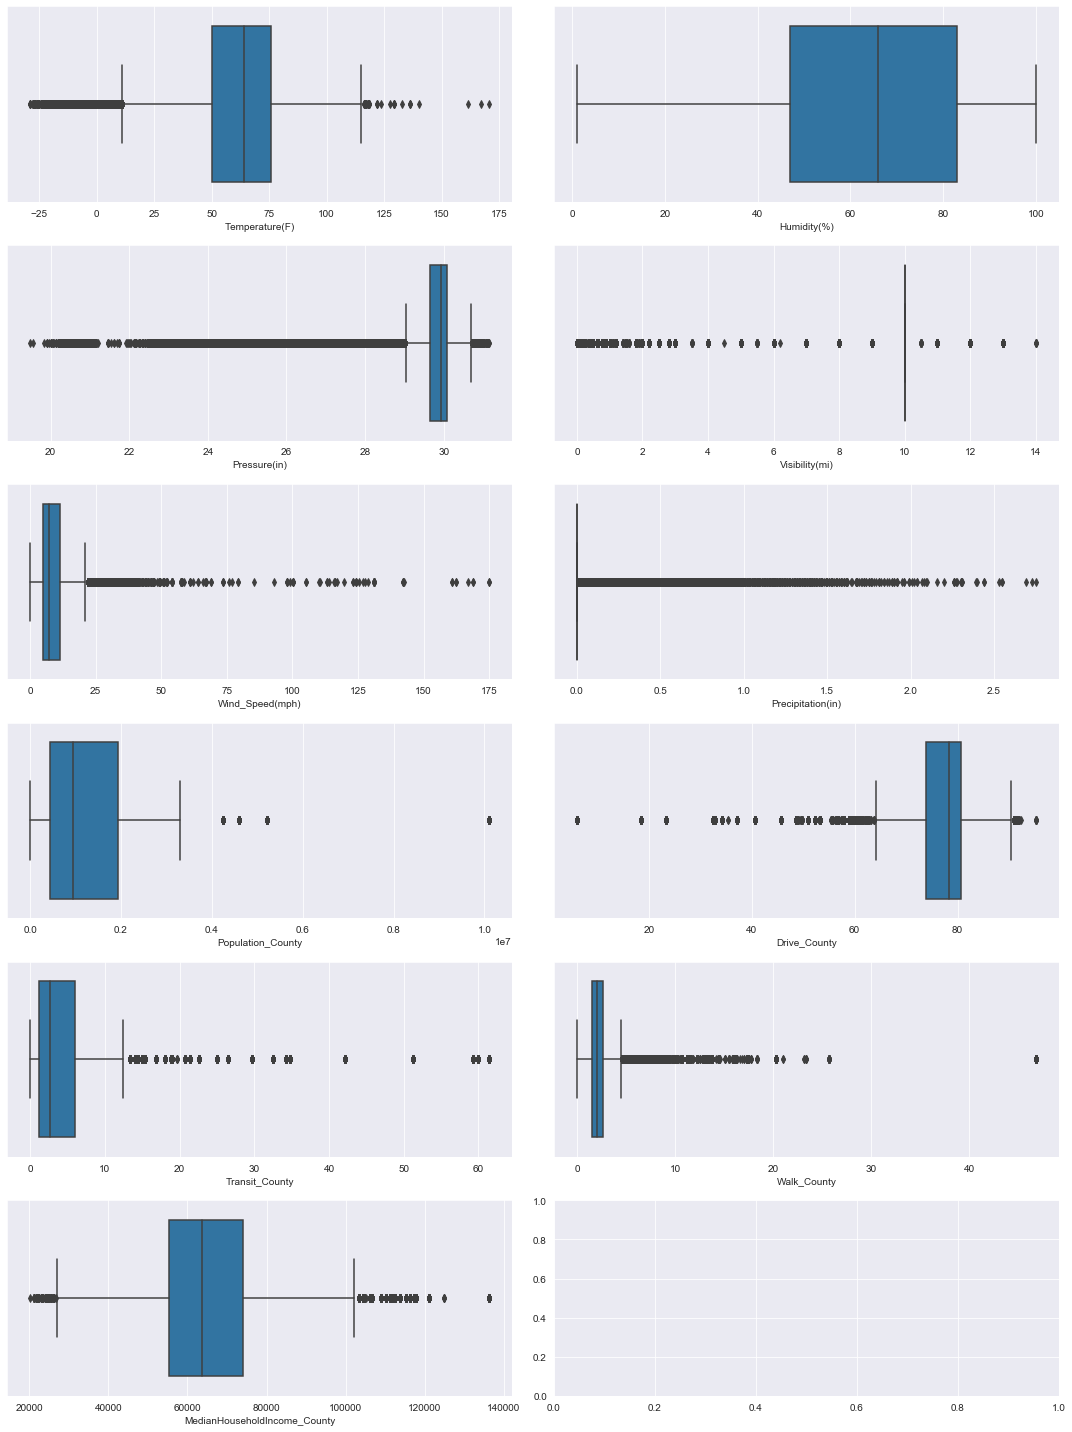

In [15]:
cols = ['Severity', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
        'Wind_Speed(mph)', 'Precipitation(in)',
       'Population_County', 'Drive_County', 'Transit_County', 'Walk_County', 'MedianHouseholdIncome_County']

sns.set_style('darkgrid')
f, axes = plt.subplots(6,2, figsize=(15,20))  
y = 0;
for name in cols[1:]:
    i, j = divmod(y, 2)
    sns.boxplot(x=data[name], ax=axes[i, j])
    y = y+1

plt.tight_layout()
plt.show()

In [19]:
data = data.reset_index(drop = True)
data.to_feather('Datasets/merged_data.feather')

In [18]:
data = data.dropna()
data

,Unnamed: 0,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Street,...,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Population_County,Drive_County,Transit_County,Walk_County,MedianHouseholdIncome_County
0,1,A-3,2.0,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,0.010,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,...,1.0,1.0,1.0,1.0,1.0,203216.0,85.4,0.4,1.1,64822.0
1,2,A-4,3.0,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,0.010,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,...,0.0,1.0,0.0,1.0,1.0,532034.0,82.6,2.6,2.5,49314.0
2,3,A-5,2.0,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,0.010,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,...,1.0,0.0,0.0,1.0,1.0,532034.0,82.6,2.6,2.5,49314.0
3,4,A-6,3.0,2016-02-08 07:44:26,2016-02-08 08:14:26,40.100590,-82.925194,0.010,Accident on I-270 Outerbelt Northbound near Ex...,Westerville Rd,...,0.0,0.0,0.0,1.0,1.0,1275333.0,81.3,2.3,2.5,58762.0
4,5,A-7,2.0,2016-02-08 07:59:35,2016-02-08 08:29:35,39.758274,-84.230507,0.000,Accident on Oakridge Dr at Woodward Ave. Expec...,N Woodward Ave,...,0.0,0.0,0.0,1.0,1.0,532034.0,82.6,2.6,2.5,49314.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934867,3003114,A-3513776,2.0,2019-08-23 18:03:25,2019-08-23 18:32:01,34.002480,-117.379400,0.543,At Market St - Accident.,Pomona Fwy E,...,0.0,0.0,0.0,1.0,1.0,2383286.0,77.8,1.3,1.5,63948.0
2934868,3003115,A-3513777,2.0,2019-08-23 19:11:30,2019-08-23 19:38:23,32.766960,-117.148100,0.338,At Camino Del Rio/Mission Center Rd - Accident.,I-8 W,...,0.0,0.0,0.0,1.0,1.0,3302833.0,76.3,2.9,2.9,74855.0
2934869,3003116,A-3513778,2.0,2019-08-23 19:00:21,2019-08-23 19:28:49,33.775450,-117.847800,0.561,At Glassell St/Grand Ave - Accident. in the ri...,Garden Grove Fwy,...,0.0,0.0,0.0,1.0,1.0,3164182.0,78.7,2.0,1.9,85398.0
2934870,3003117,A-3513779,2.0,2019-08-23 19:00:21,2019-08-23 19:29:42,33.992460,-118.403000,0.772,At CA-90/Marina Fwy/Jefferson Blvd - Accident.,San Diego Fwy S,...,0.0,0.0,0.0,1.0,1.0,10098052.0,73.9,6.0,2.7,64251.0
